In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture

from tools import *
from plot import plot_two_figures, plot_each_labels, plot_confusion_matrix
from preprocessing import RX_anomaly_detector

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
# Reshaping the HSI as a 2D matrix
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [8]:
indiana_class_names = np.arange(n_cluster_indiana).astype(str)
salinas_class_names = np.arange(n_cluster_salinas).astype(str)

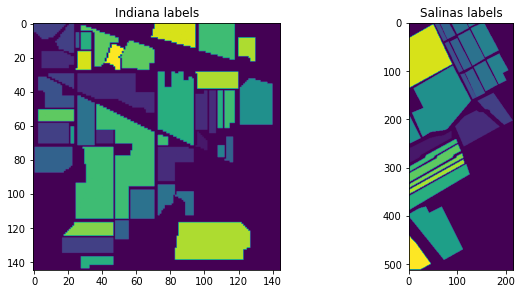

In [9]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

 ## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [10]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [11]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [12]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [13]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


## RX anomaly detector

The Reed-Xiaoli Detector (RXD) algorithm is used to detect anomalies in hyperspectral imaging. It calculates a distance between the data sample with the background to determine anomalies.

In [14]:
X_indiana_reduced_img = X_indiana_reduced.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))
X_salinas_reduced_img = X_salinas_reduced.reshape((salinas_img.shape[0], salinas_img.shape[1], X_salinas_reduced.shape[1]))

In [15]:
indiana_anomalies = RX_anomaly_detector(X_indiana_reduced_img)
salinas_anomalies = RX_anomaly_detector(X_salinas_reduced_img)

In [16]:
outlier_indiana_pos = np.argwhere(indiana_anomalies == True).tolist()
outlier_salinas_pos = np.argwhere(salinas_anomalies == True).tolist()

In [17]:
X_salinas_no_outlier, X_salinas_outlier_positions = copy_without_outlier(X_salinas_reduced_img, outlier_salinas_pos)
X_indiana_no_outlier, X_indiana_outlier_positions = copy_without_outlier(X_indiana_reduced_img, outlier_indiana_pos)

# Gaussian Mixture

A gaussian mixture model is used for unsupervised learning. It is a probalistic model that represents normally distributed subpopulations within an overall population.

## Salinas image with outliers

In [18]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [19]:
%%time
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
CPU times: user 21.9 s, sys: 34.3 s, total: 56.2 s
Wall time: 7.53 s


GaussianMixture(n_components=16, verbose=1)

In [20]:
%%time
salinas_preds = salinas_model.predict(X_salinas_reduced)
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

CPU times: user 287 ms, sys: 940 ms, total: 1.23 s
Wall time: 164 ms


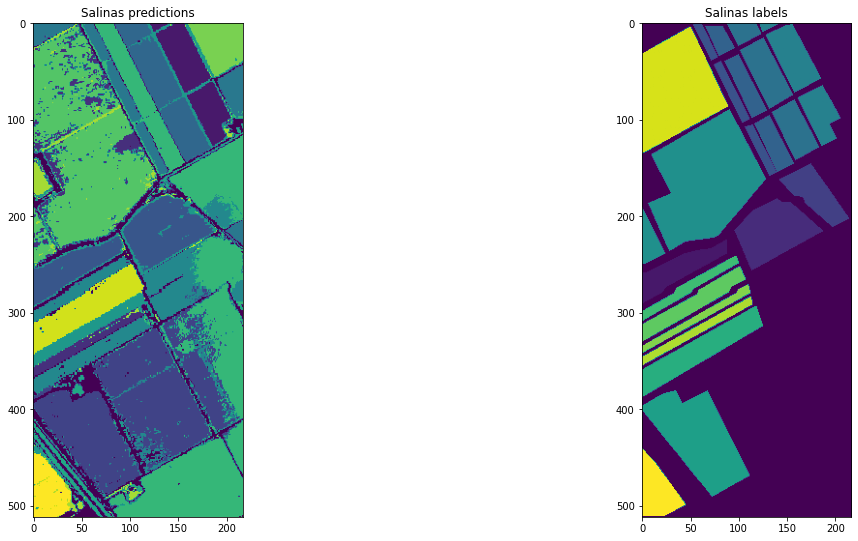

In [21]:
plot_two_figures(salinas_preds, salinas_labels, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

We can see that this model manages to classify some parts of the image but we can't get much information from it because the unclassified data has not been removed.

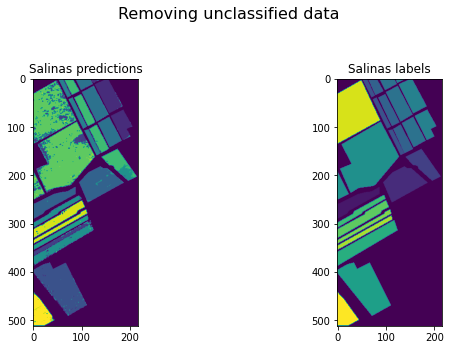

In [22]:
salinas_preds_corrected = remove_unclassified(salinas_preds, salinas_labels)
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Salinas predictions', 'Salinas labels', suptitle='Removing unclassified data')

Now, we can see that this model is effective in distinguishing the different classes on the salinas image. Apart from the two parts at the top left, the parts do not have a lot of noise. The current objective is to verify that each class is well recognized. We will sort our prediction data and match the most present class to the one that is most preponderant in the ground truth.

In [23]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

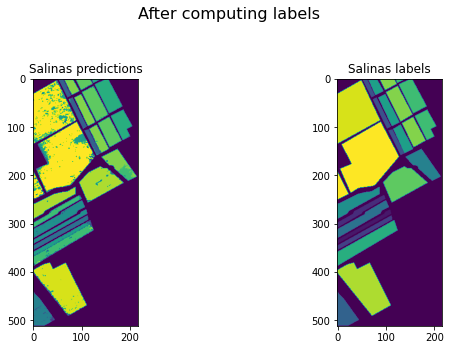

In [24]:
plot_two_figures(salinas_final_preds, salinas_labels_cpy, 'Salinas predictions', 'Salinas labels', suptitle='After computing labels')

It seems that this model is effective, most labels are well recognized when we look at the whole image.

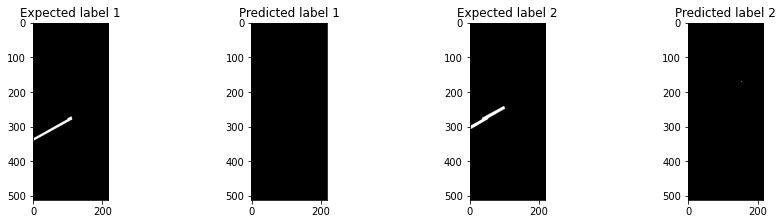

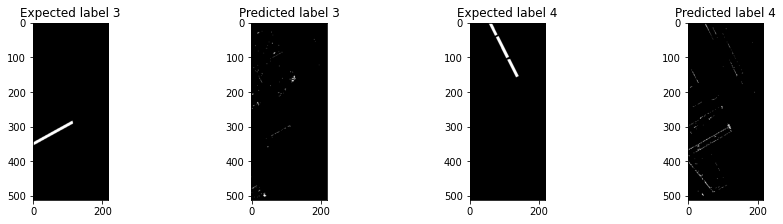

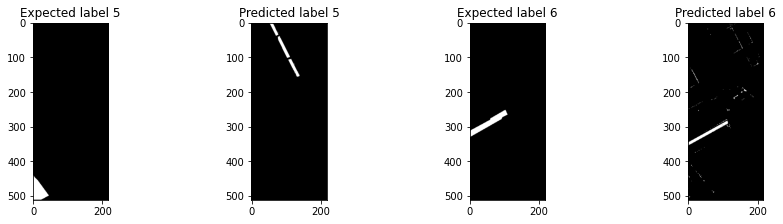

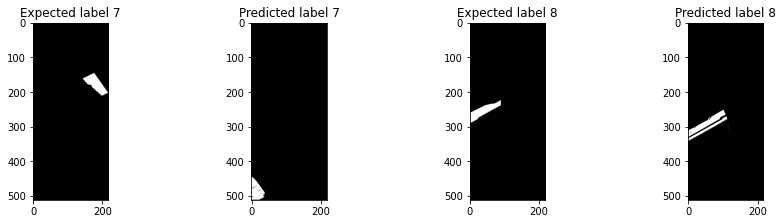

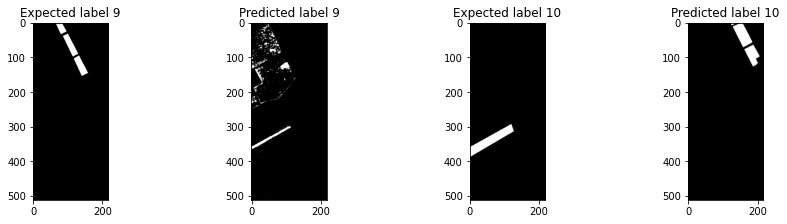

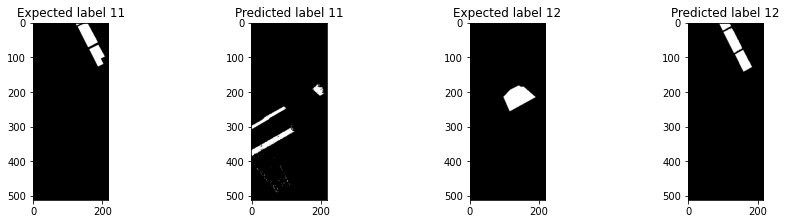

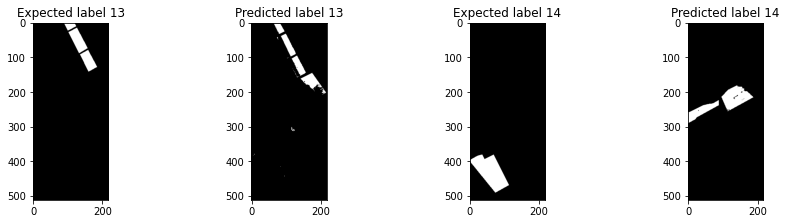

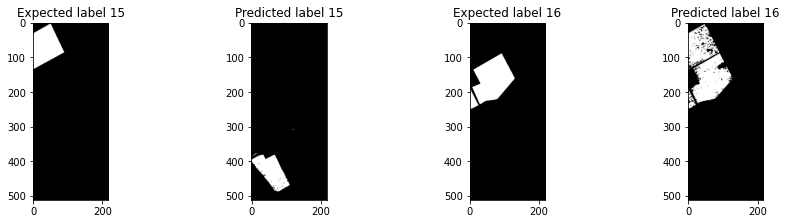

In [25]:
plot_each_labels(salinas_labels_cpy, salinas_final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

In [26]:
for i in range(1, n_cluster_salinas + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, salinas_labels_cpy[salinas_labels_cpy == i].size, salinas_final_preds[salinas_final_preds == i].size))

label  1: expected   916 - predicted     0
label  2: expected  1068 - predicted     4
label  3: expected  1070 - predicted   359
label  4: expected  1394 - predicted   804
label  5: expected  1807 - predicted  1368
label  6: expected  1927 - predicted  1510
label  7: expected  1976 - predicted  1681
label  8: expected  2009 - predicted  2780
label  9: expected  2678 - predicted  3227
label 10: expected  3278 - predicted  3523
label 11: expected  3579 - predicted  3598
label 12: expected  3726 - predicted  3872
label 13: expected  3959 - predicted  4108
label 14: expected  6203 - predicted  5624
label 15: expected  7268 - predicted  5897
label 16: expected 11271 - predicted 15774


We can look at each class in detail. We can notice that the first four labels are not well recognized, but the others are sufficiently recognized. Obviously, our method to match each label is not the best since some classes contain a fairly close number of samples.

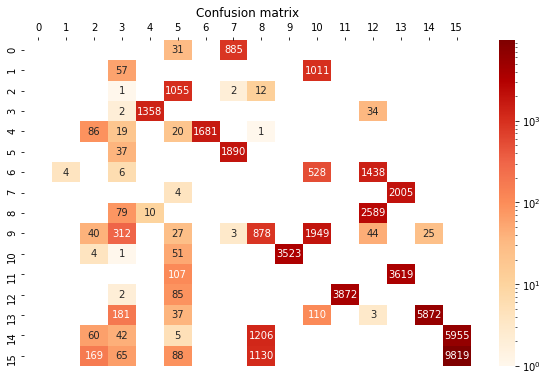

In [27]:
plot_confusion_matrix(salinas_labels_cpy[salinas_labels_cpy != 0], salinas_final_preds[salinas_final_preds != 0], salinas_class_names, log=True)

With the confusion matrix, we can slightly distinguish the diagonal of the matrix but there are still a lot of errors.

As an unsupervised model, the Gaussian mixture is the best model we have tested. Although two classes are not recognized, 

In [28]:
# Save predictions
np.save('../data/predictions/salinas_preds_gmm_with_outliers.npy', salinas_final_preds)

## Salinas without outliers

We will perform the same operations on the data without outliers.

In [29]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [30]:
%%time
salinas_model.fit(X_salinas_no_outlier)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
CPU times: user 23.2 s, sys: 42.9 s, total: 1min 6s
Wall time: 9.19 s


GaussianMixture(n_components=16, verbose=1)

In [31]:
%%time
salinas_preds = salinas_model.predict(X_salinas_no_outlier)

CPU times: user 372 ms, sys: 1 s, total: 1.37 s
Wall time: 195 ms


In [32]:
salinas_preds_outliers = rebuild_data_with_outliers(salinas_preds, X_salinas_outlier_positions, outlier_salinas_pos, (salinas_img.shape[0], salinas_img.shape[1]))

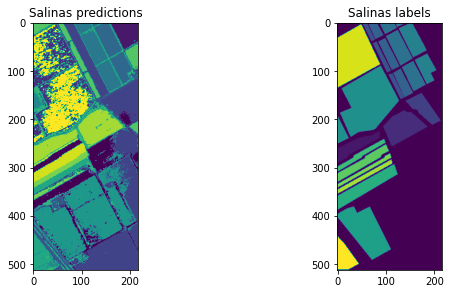

In [33]:
plot_two_figures(salinas_preds_outliers, salinas_labels, 'Salinas predictions', 'Salinas labels')

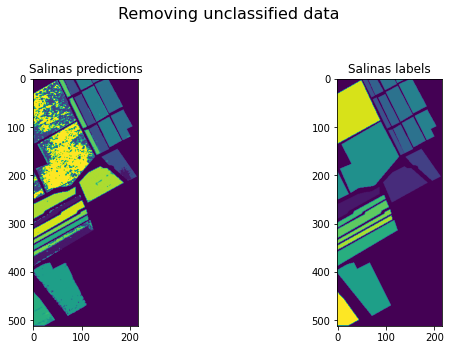

In [34]:
salinas_preds_corrected = remove_unclassified(salinas_preds_outliers, salinas_labels)
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Salinas predictions', 'Salinas labels', suptitle='Removing unclassified data')

In [35]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

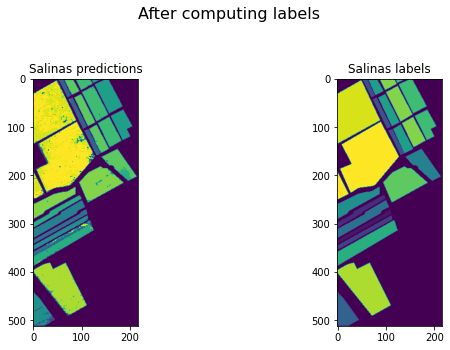

In [36]:
plot_two_figures(salinas_final_preds, salinas_labels_cpy, 'Salinas predictions', 'Salinas labels', suptitle='After computing labels')

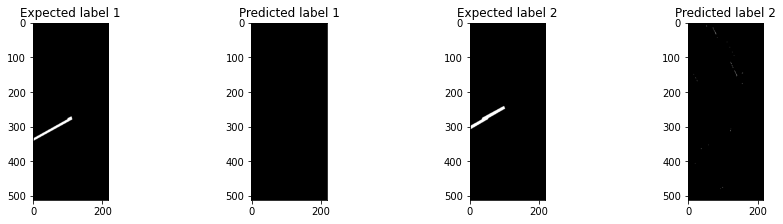

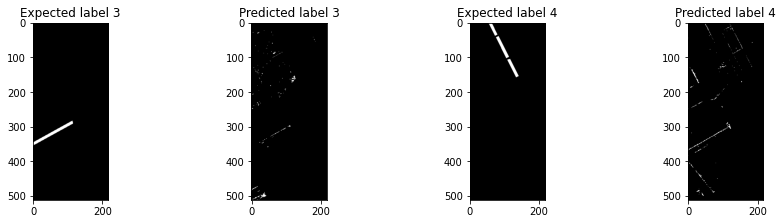

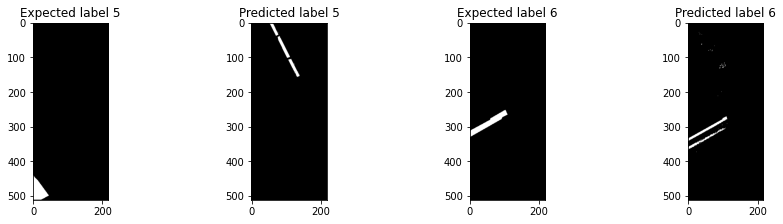

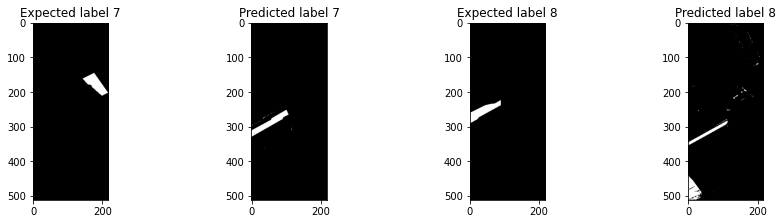

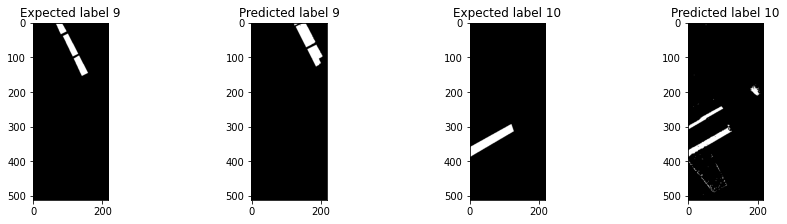

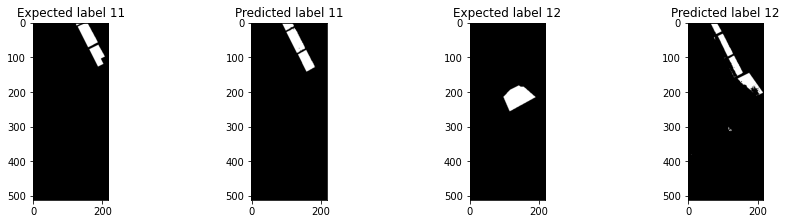

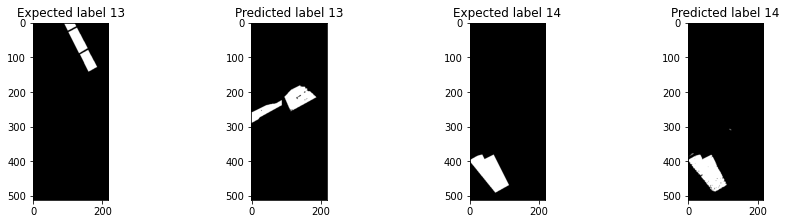

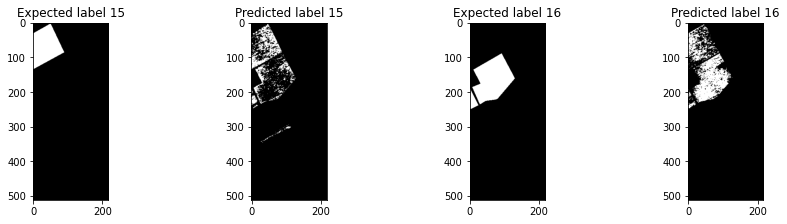

In [37]:
plot_each_labels(salinas_labels_cpy, salinas_final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

In [38]:
for i in range(1, n_cluster_salinas + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, salinas_labels_cpy[salinas_labels_cpy == i].size, salinas_final_preds[salinas_final_preds == i].size))

label  1: expected   916 - predicted     0
label  2: expected  1068 - predicted    68
label  3: expected  1070 - predicted   529
label  4: expected  1394 - predicted   882
label  5: expected  1807 - predicted  1372
label  6: expected  1927 - predicted  1550
label  7: expected  1976 - predicted  1960
label  8: expected  2009 - predicted  2847
label  9: expected  2678 - predicted  3514
label 10: expected  3278 - predicted  3738
label 11: expected  3579 - predicted  3848
label 12: expected  3726 - predicted  4282
label 13: expected  3959 - predicted  5617
label 14: expected  6203 - predicted  5850
label 15: expected  7268 - predicted  6974
label 16: expected 11271 - predicted 11098


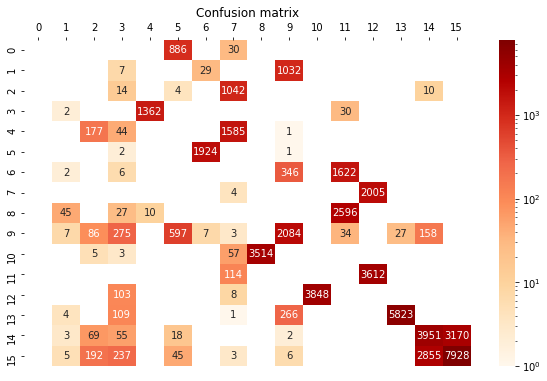

In [39]:
plot_confusion_matrix(salinas_labels_cpy[salinas_labels_cpy != 0], salinas_final_preds[salinas_final_preds != 0], salinas_class_names, log=True)

As we can see, the model is able to recognize one more class, but it seems that there are no improvements.

In [40]:
# Save predictions
np.save('../data/predictions/salinas_preds_gmm_without_outliers.npy', salinas_final_preds)

## Indiana with outliers

We will perform the same operations on indiana image.

In [41]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [42]:
%%time
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
Initialization converged: True
CPU times: user 1min 5s, sys: 48.6 s, total: 1min 54s
Wall time: 15.4 s


GaussianMixture(n_components=16, verbose=1)

In [43]:
%%time
indiana_preds = indiana_model.predict(X_indiana_reduced)
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))

CPU times: user 930 ms, sys: 1.14 s, total: 2.06 s
Wall time: 283 ms


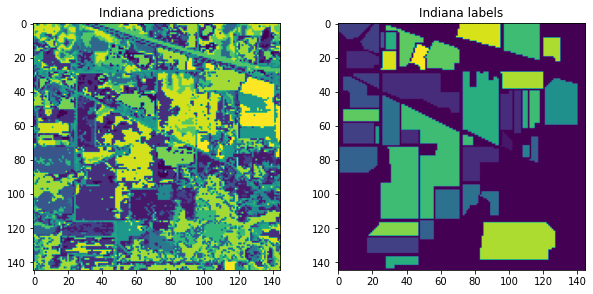

In [44]:
plot_two_figures(indiana_preds, indiana_labels, 'Indiana predictions', 'Indiana labels')

Before removing unclassified data, it is impossible to process the image of the predictions. It is too difficult to recognize some labels.

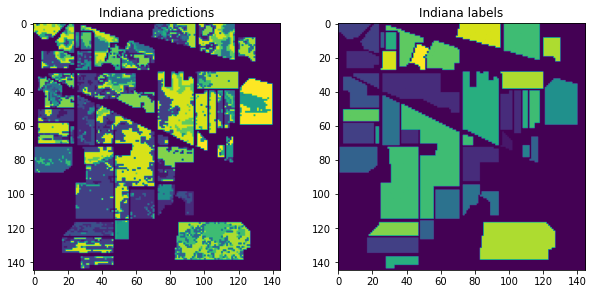

In [45]:
indiana_preds_corrected = remove_unclassified(indiana_preds, indiana_labels)
plot_two_figures(indiana_preds_corrected, indiana_labels, 'Indiana predictions', 'Indiana labels')

We can notice that the model is not effective on this image. There is a lot of noise on every block of the image.

In [46]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

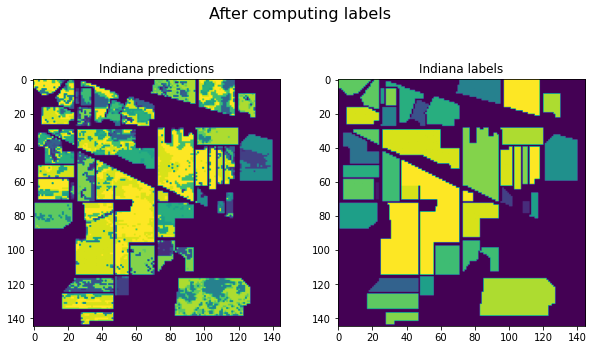

In [47]:
plot_two_figures(indiana_final_preds, indiana_labels_cpy, 'Indiana predictions', 'Indiana labels', suptitle='After computing labels')

In [48]:
for i in range(1, n_cluster_indiana + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, indiana_labels_cpy[indiana_labels_cpy == i].size, indiana_final_preds[indiana_final_preds == i].size))

label  1: expected    20 - predicted    44
label  2: expected    28 - predicted   247
label  3: expected    46 - predicted   275
label  4: expected    93 - predicted   306
label  5: expected   205 - predicted   322
label  6: expected   237 - predicted   341
label  7: expected   386 - predicted   357
label  8: expected   478 - predicted   402
label  9: expected   483 - predicted   434
label 10: expected   593 - predicted   556
label 11: expected   730 - predicted   569
label 12: expected   830 - predicted   604
label 13: expected   972 - predicted   713
label 14: expected  1265 - predicted   777
label 15: expected  1428 - predicted  2124
label 16: expected  2455 - predicted  2178


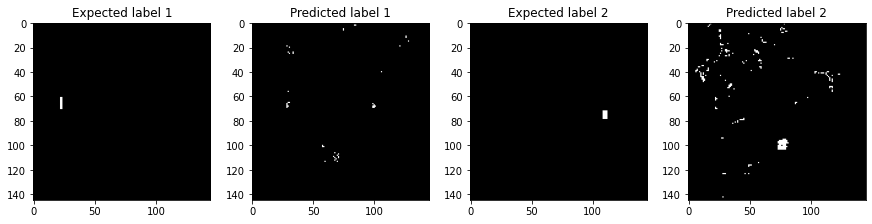

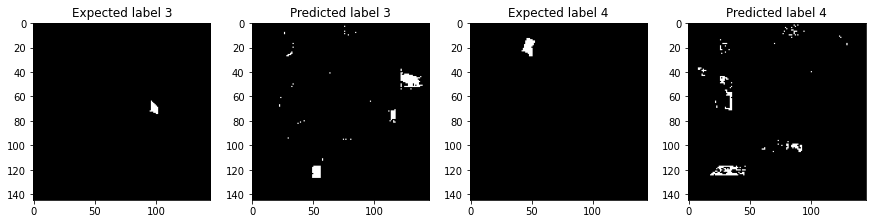

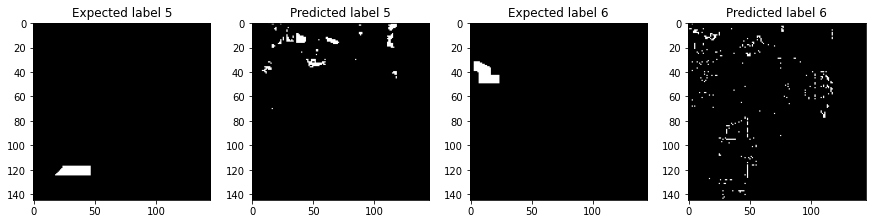

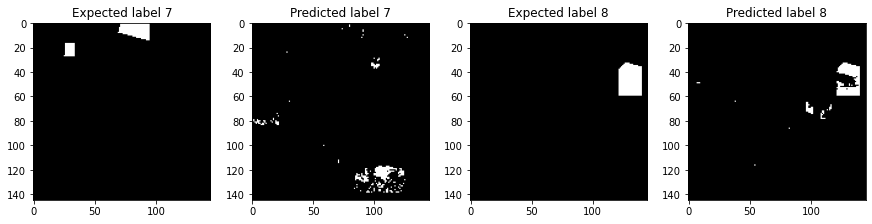

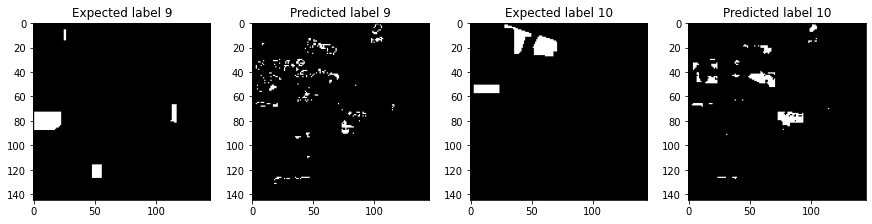

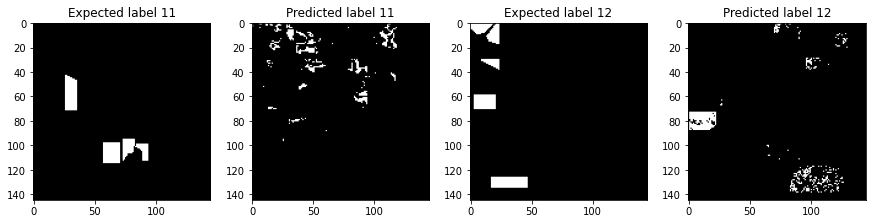

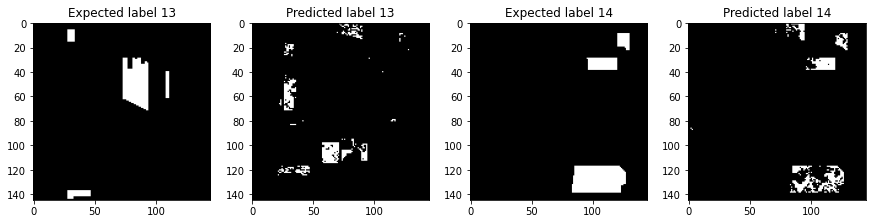

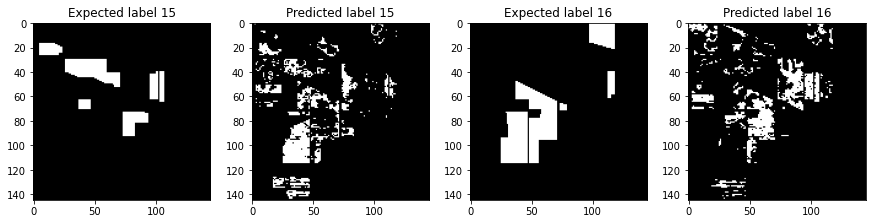

In [49]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

As we can see, it is difficult for the model to distinguish each label.

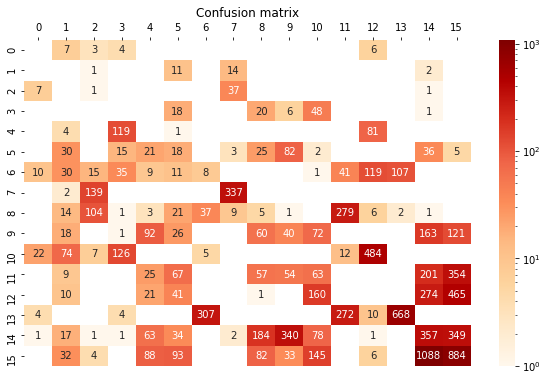

In [50]:
plot_confusion_matrix(indiana_labels_cpy[indiana_labels_cpy != 0], indiana_final_preds[indiana_final_preds != 0], indiana_class_names, log=True)

Furthermore, there is a huge amount of error when we look at the confusion matrix since a large part of the cases are colored.

In [51]:
# Save predictions
np.save('../data/predictions/indiana_preds_gmm_with_outliers.npy', indiana_final_preds)

## Indiana without outliers

We will perform the same operations on indiana image without outliers.

In [52]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [53]:
%%time
indiana_model.fit(X_indiana_no_outlier)

Initialization 0
  Iteration 10
Initialization converged: True
CPU times: user 56.1 s, sys: 1min, total: 1min 56s
Wall time: 17 s


GaussianMixture(n_components=16, verbose=1)

In [54]:
%%time
indiana_preds = indiana_model.predict(X_indiana_no_outlier)

CPU times: user 959 ms, sys: 956 ms, total: 1.91 s
Wall time: 299 ms


In [55]:
indiana_preds_outliers = rebuild_data_with_outliers(indiana_preds, X_indiana_outlier_positions, outlier_indiana_pos, (indiana_img.shape[0], indiana_img.shape[1]))

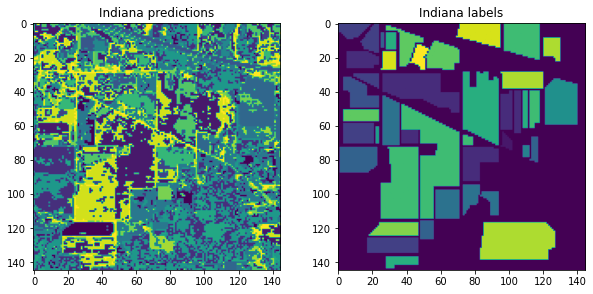

In [56]:
plot_two_figures(indiana_preds_outliers, indiana_labels, 'Indiana predictions', 'Indiana labels')

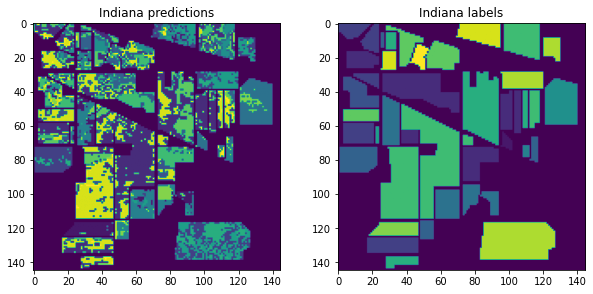

In [57]:
indiana_preds_corrected = remove_unclassified(indiana_preds_outliers, indiana_labels)
plot_two_figures(indiana_preds_corrected, indiana_labels, 'Indiana predictions', 'Indiana labels')

In [58]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

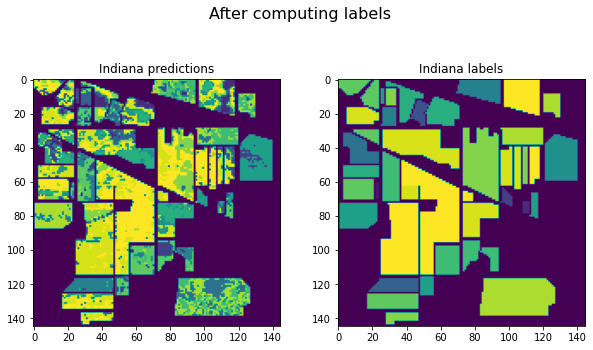

In [59]:
plot_two_figures(indiana_final_preds, indiana_labels_cpy, 'Indiana predictions', 'Indiana labels', suptitle='After computing labels')

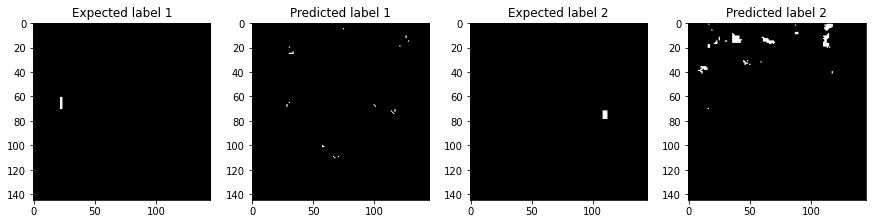

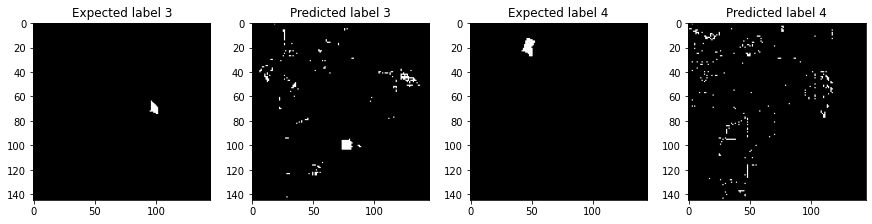

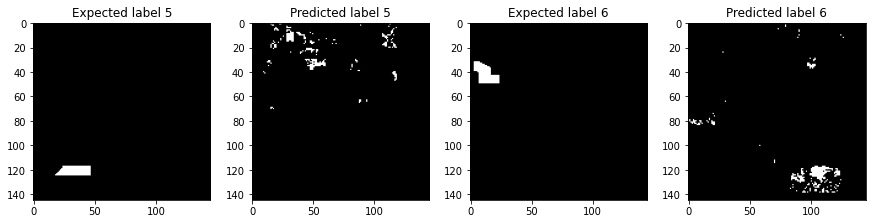

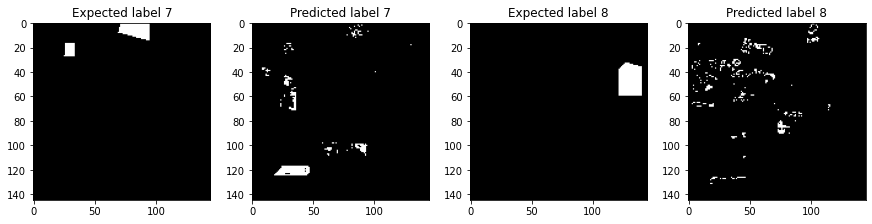

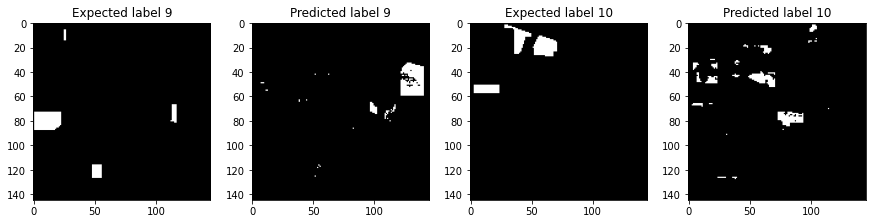

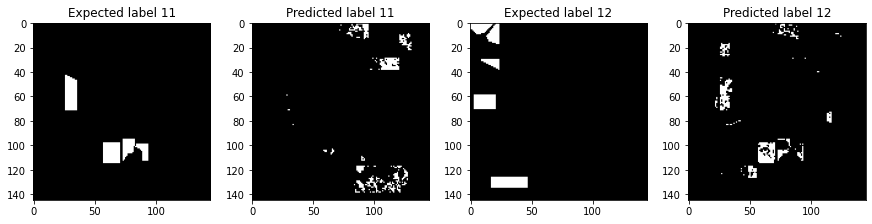

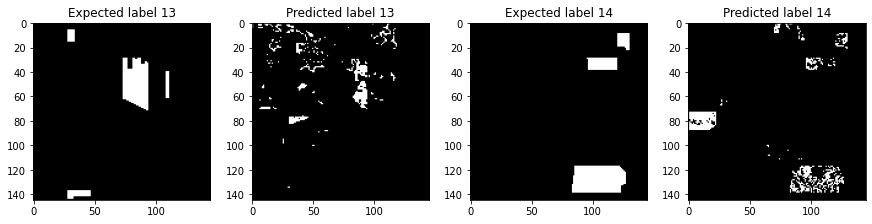

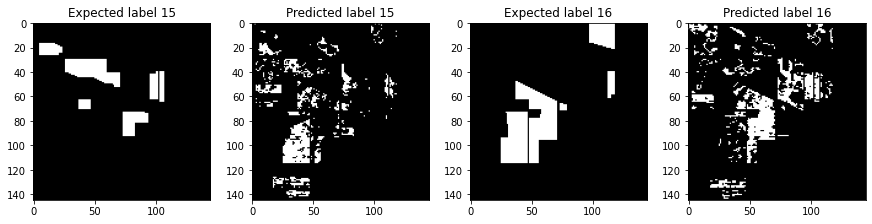

In [60]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

Gaussian Mixture is not better on Indiana image without outliers. It is diffcult to recognize a label.

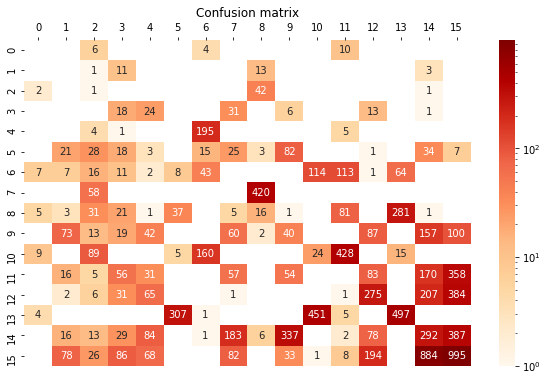

In [61]:
plot_confusion_matrix(indiana_labels_cpy[indiana_labels_cpy != 0], indiana_final_preds[indiana_final_preds != 0], indiana_class_names, log=True)

The confusion matrix on Indiana image without outliers looks a little bit better but too many samples are classified to label 14.

In [62]:
# Save predictions
np.save('../data/predictions/indiana_preds_gmm_without_outliers.npy', indiana_final_preds)